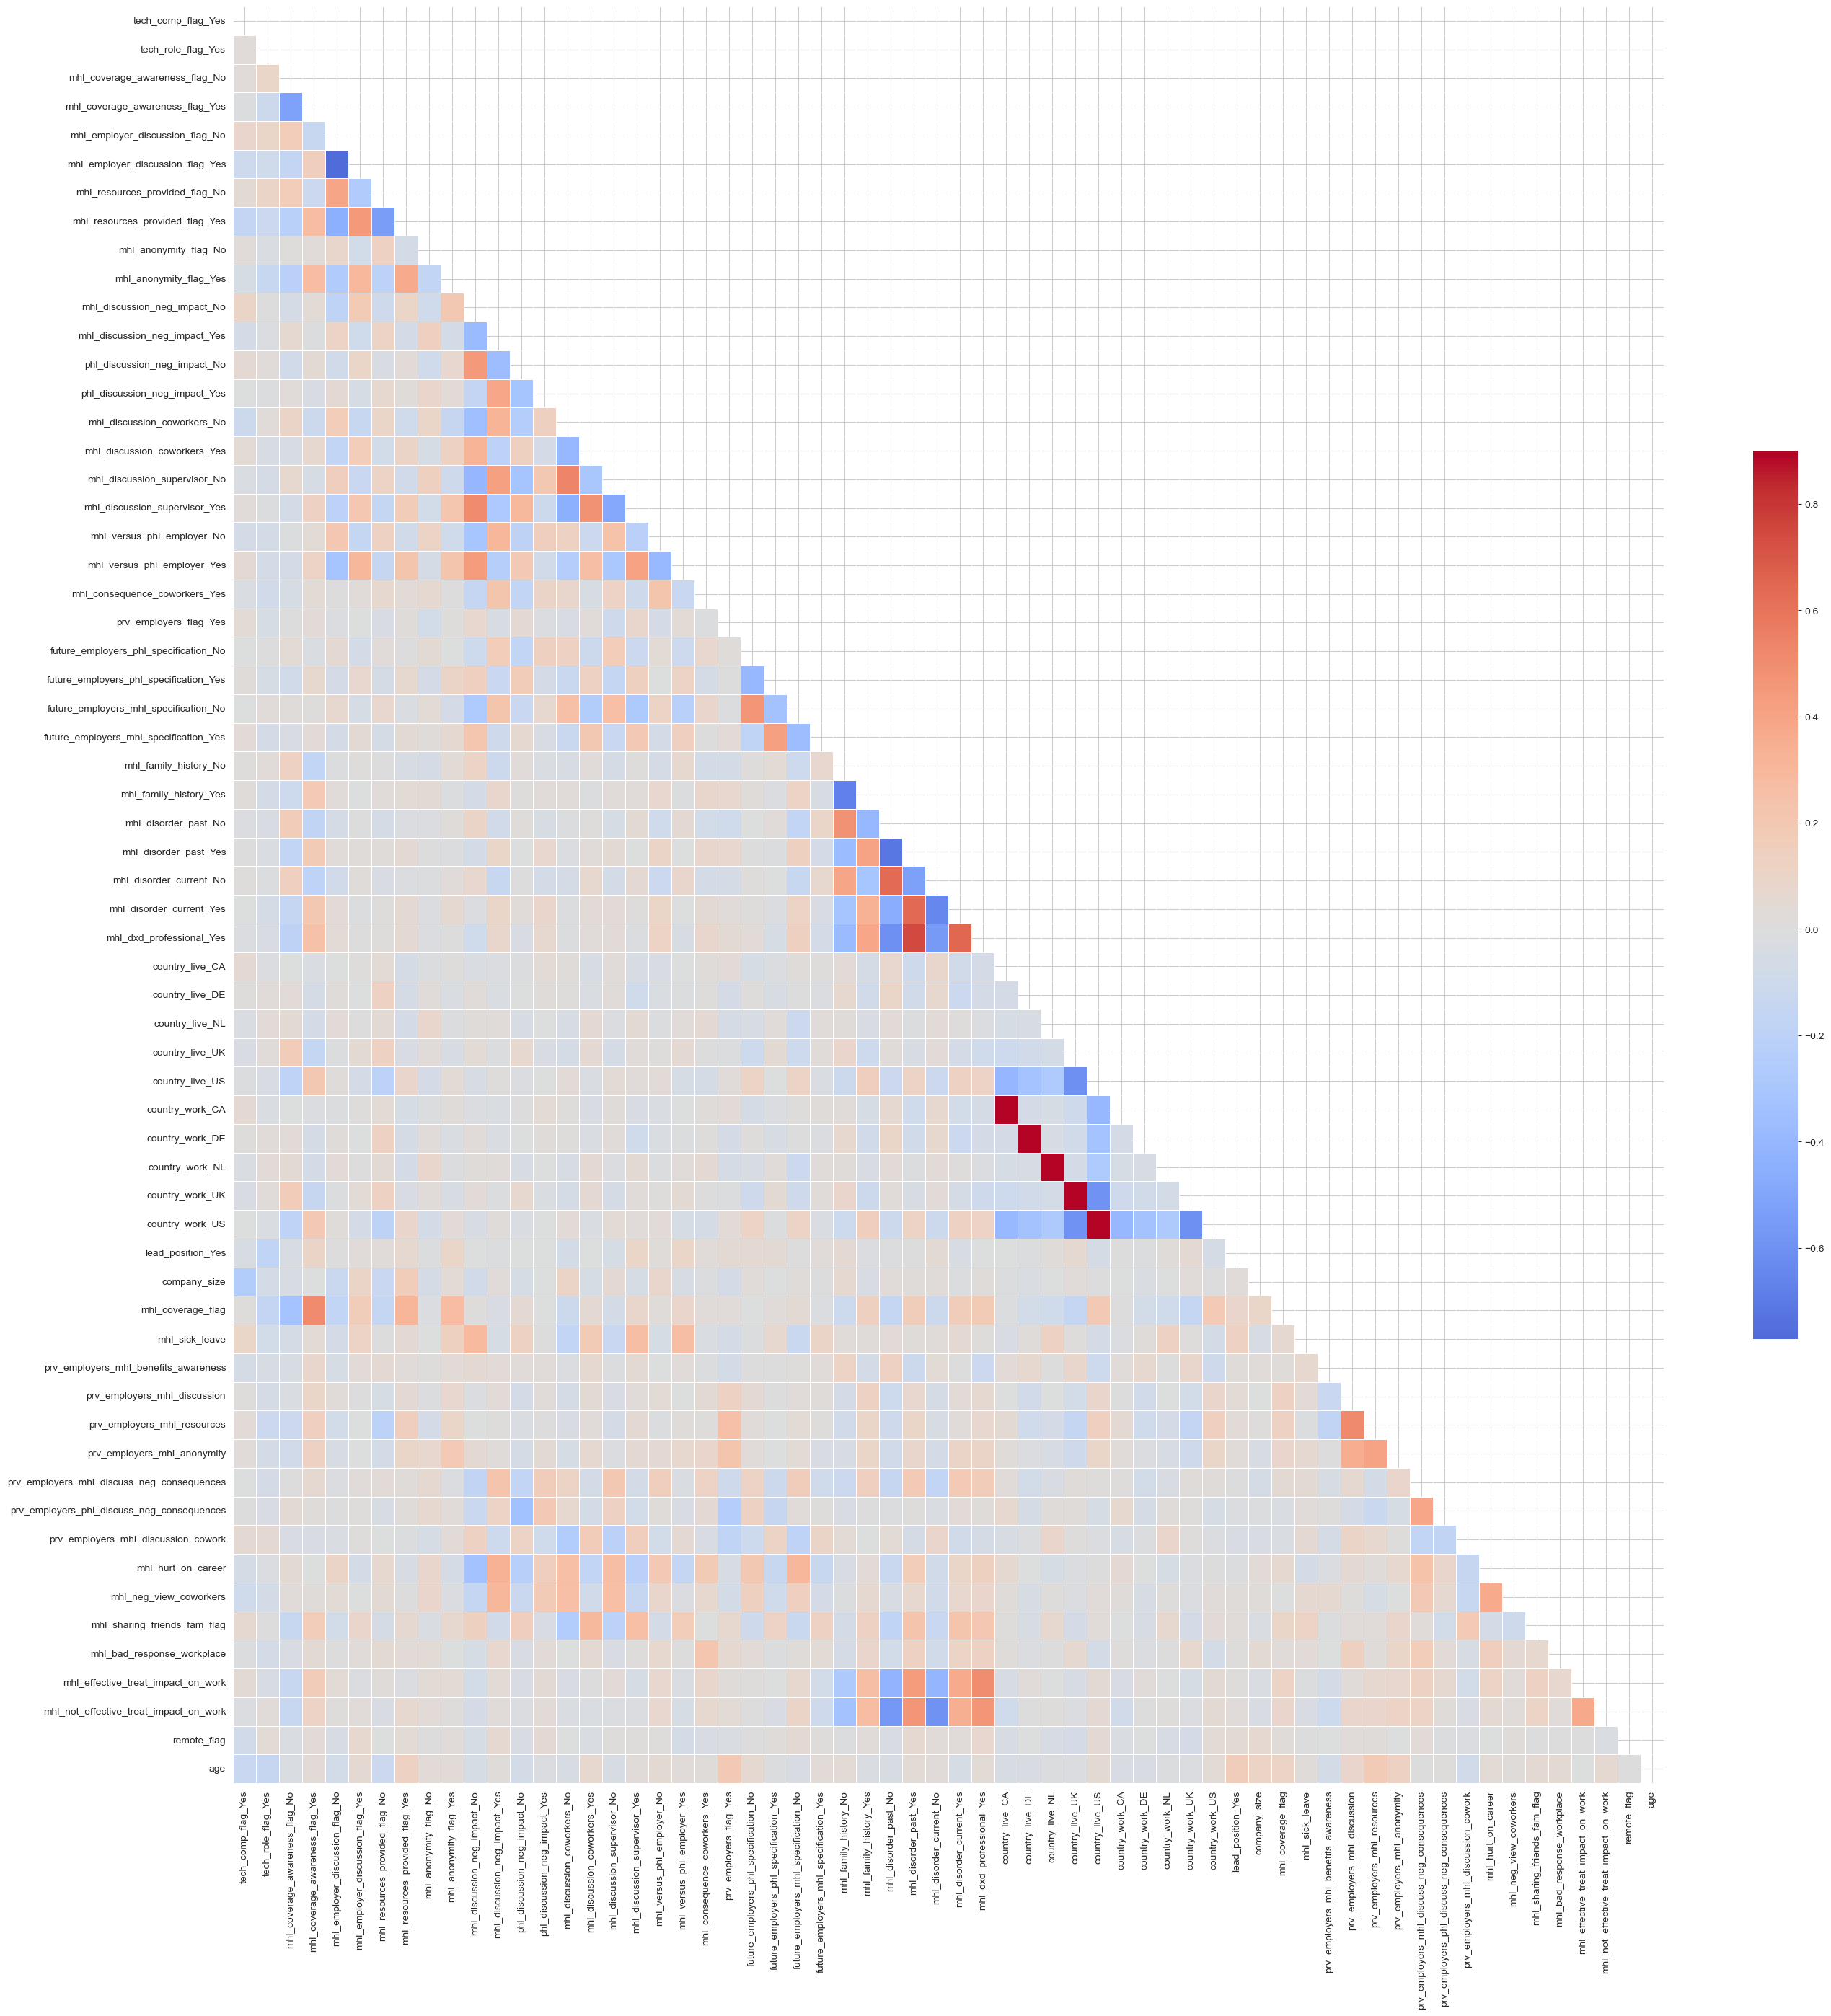

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the encoded dataframe from pickle
encoded_df = pd.read_pickle('encoded_data/encoded_data.pkl')

corr = encoded_df.corr(method ='spearman')
mask_1 = np.zeros_like(corr, dtype=bool)
mask_1[np.triu_indices_from(mask_1)] = True
fig, ax = plt.subplots(figsize=(32, 32))
sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, mask=mask_1, cmap="coolwarm", vmax=.9, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [2]:
correlations = encoded_df.corr().unstack().sort_values(ascending=False) # Building correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Converting to dataframe
correlations.columns = ['V1', 'V2', 'correlation'] # Labeling the columns for easier processing
correlations.query("V1 == 'mhl_dxd_professional_Yes' & V2 != 'mhl_dxd_professional_Yes'").nlargest(10,columns="correlation") # Filtering by variable treatment

,V1,V2,correlation
72,mhl_dxd_professional_Yes,mhl_disorder_past_Yes,0.744301
75,mhl_dxd_professional_Yes,mhl_disorder_current_Yes,0.646473
83,mhl_dxd_professional_Yes,mhl_effective_treat_impact_on_work,0.530536
124,mhl_dxd_professional_Yes,mhl_family_history_Yes,0.386589
132,mhl_dxd_professional_Yes,mhl_not_effective_treat_impact_on_work,0.361924
190,mhl_dxd_professional_Yes,mhl_coverage_awareness_flag_Yes,0.243186
255,mhl_dxd_professional_Yes,mhl_sharing_friends_fam_flag,0.193853
275,mhl_dxd_professional_Yes,mhl_coverage_flag,0.179180
291,mhl_dxd_professional_Yes,prv_employers_mhl_discuss_neg_consequences,0.172937
387,mhl_dxd_professional_Yes,future_employers_mhl_specification_No,0.138303


ANOVA

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Define V1 as the target variable (which should be a 1D array)
V1 = encoded_df['mhl_dxd_professional_Yes']

# Define V2 as the feature matrix, dropping the target variable
V2 = encoded_df.drop(["mhl_dxd_professional_Yes"], axis=1)

# Flatten V1 to 1D array (for target variable)
V1 = V1.values.ravel()  # This flattens V1 to be a 1D array

# Initialize SelectKBest with ANOVA F-value as the score function and k=2
selector = SelectKBest(score_func=f_classif, k=2)

# Fit and transform the data
V1_new = selector.fit_transform(V2, V1)

# Display the scores and p-values of the features
feature_scores = pd.DataFrame({
    'features': V2.columns,
    'Scores': selector.scores_,
    'p-values': selector.pvalues_
}).sort_values(by="Scores", ascending=False).nlargest(n=10, columns="Scores")

print(feature_scores)


                                  features       Scores       p-values
29                   mhl_disorder_past_Yes  1222.197363  1.032268e-174
31                mhl_disorder_current_Yes   706.509738  9.184639e-118
28                    mhl_disorder_past_No   573.879196  2.808062e-100
30                 mhl_disorder_current_No   441.546708   2.841664e-81
57      mhl_effective_treat_impact_on_work   385.460485   1.123910e-72
27                  mhl_family_history_Yes   172.900267   1.688908e-36
26                   mhl_family_history_No   167.433319   1.760281e-35
58  mhl_not_effective_treat_impact_on_work   148.321846   6.986251e-32
3          mhl_coverage_awareness_flag_Yes    61.850825   9.707860e-15
2           mhl_coverage_awareness_flag_No    39.156987   5.827041e-10


In [4]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import pandas as pd

# Define y (target variable)
V2 = encoded_df['mhl_dxd_professional_Yes']

# Define X (features) by dropping the target column
V1 = encoded_df.drop(['mhl_dxd_professional_Yes'], axis=1)

# Initialize SelectKBest with mutual_info_classif and select top 15 features
selector = SelectKBest(score_func=mutual_info_classif, k=15)

# Fit the selector to the data
V1_new = selector.fit_transform(V1, V2)

# Create a DataFrame to display the features, scores, and sorted results
feature_scores = pd.DataFrame({
    'features': V1.columns.values,  # Feature names
    'Scores': selector.scores_  # Mutual information scores
})

# Sort the features by Scores in descending order and show the top 15 features
feature_scores_sorted = feature_scores.sort_values(by="Scores", ascending=False).nlargest(n=15, columns="Scores")

# Display the sorted table
print(feature_scores_sorted)


                                      features    Scores
57          mhl_effective_treat_impact_on_work  0.316975
29                       mhl_disorder_past_Yes  0.316466
58      mhl_not_effective_treat_impact_on_work  0.265599
31                    mhl_disorder_current_Yes  0.232551
28                        mhl_disorder_past_No  0.209098
30                     mhl_disorder_current_No  0.156558
26                       mhl_family_history_No  0.058250
56                  mhl_bad_response_workplace  0.048246
3              mhl_coverage_awareness_flag_Yes  0.048088
27                      mhl_family_history_Yes  0.044961
18                  mhl_versus_phl_employer_No  0.043808
55                mhl_sharing_friends_fam_flag  0.042659
5             mhl_employer_discussion_flag_Yes  0.038061
6               mhl_resources_provided_flag_No  0.032059
50  prv_employers_mhl_discuss_neg_consequences  0.029651


In [5]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Define target and features
target_col = "mhl_dxd_professional_Yes"
Y = encoded_df[target_col]
X = encoded_df.drop(columns=[target_col])

# Initialize and apply selector
selector = SelectKBest(score_func=f_classif, k='all')  # Use 'all' to get scores for all features
selector.fit(X, Y)

# Create a DataFrame with scores and p-values
scores_df = pd.DataFrame({
    'features': X.columns,
    'Scores': selector.scores_,
    'p-values': selector.pvalues_
})

# Show top 10 features by ANOVA F-value score
top_features = scores_df.sort_values(by="Scores", ascending=False).head(10)
top_features

,features,Scores,p-values
29,mhl_disorder_past_Yes,1222.197363,1.032268e-174
31,mhl_disorder_current_Yes,706.509738,9.184639e-118
28,mhl_disorder_past_No,573.879196,2.808062e-100
30,mhl_disorder_current_No,441.546708,2.841664e-81
57,mhl_effective_treat_impact_on_work,385.460485,1.123910e-72
27,mhl_family_history_Yes,172.900267,1.688908e-36
26,mhl_family_history_No,167.433319,1.760281e-35
58,mhl_not_effective_treat_impact_on_work,148.321846,6.986251e-32
3,mhl_coverage_awareness_flag_Yes,61.850825,9.707860e-15
2,mhl_coverage_awareness_flag_No,39.156987,5.827041e-10



Chi Square Test

In [6]:
from sklearn.feature_selection import SelectKBest, chi2

# Assign X,y to target and features
y = encoded_df.mhl_dxd_professional_Yes
X = encoded_df.drop(['mhl_dxd_professional_Yes'],axis=1)

# Initiate Chi Square TEst
selector = SelectKBest(chi2, k=8)
selector.fit(X,y)
X_new = selector.transform(X)

# Create data frame showcasing the results
chi_square_test_result = pd.DataFrame({
    'features': X.columns.values,
     'Scores': selector.scores_,
     'p-values': selector.pvalues_
     }).sort_values(by="Scores").nlargest(8,columns="Scores")
chi_square_test_result

,features,Scores,p-values
29,mhl_disorder_past_Yes,259.264368,2.482373e-58
57,mhl_effective_treat_impact_on_work,250.535198,1.985008e-56
28,mhl_disorder_past_No,248.282780,6.149137e-56
31,mhl_disorder_current_Yes,240.308050,3.369279e-54
30,mhl_disorder_current_No,192.967090,7.156574e-44
26,mhl_family_history_No,96.263375,1.005734e-22
58,mhl_not_effective_treat_impact_on_work,80.214525,3.358891e-19
27,mhl_family_history_Yes,76.070720,2.736855e-18


Mutual information

In [7]:
# Create list of all selected features
selected_features = chi_square_test_result.features.to_list()

# Add target variable to list
selected_features.append("mhl_dxd_professional_Yes")

# Create new dataframe with all selected features by subsetting the encoded dataframe
selected_features_df = encoded_df[selected_features]
selected_features_df.head()

,mhl_disorder_past_Yes,mhl_effective_treat_impact_on_work,mhl_disorder_past_No,mhl_disorder_current_Yes,mhl_disorder_current_No,mhl_family_history_No,mhl_not_effective_treat_impact_on_work,mhl_family_history_Yes,mhl_dxd_professional_Yes
0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1.0,3.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,1.0,4.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0
4,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0


In [8]:
import os

# Create the directory named 'processed_data' if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Save the selected features CSV inside the 'processed_data' folder
selected_features_df.to_csv('processed_data/selected_features.csv', index=False)
